In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv("../data/inverse/data_raw.csv")
df.head()

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171142,0,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3
1,171152,0,0.0,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6
2,171177,0,0.0,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4
3,171178,0,0.0,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6
4,171180,0,0.0,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4


<AxesSubplot: >

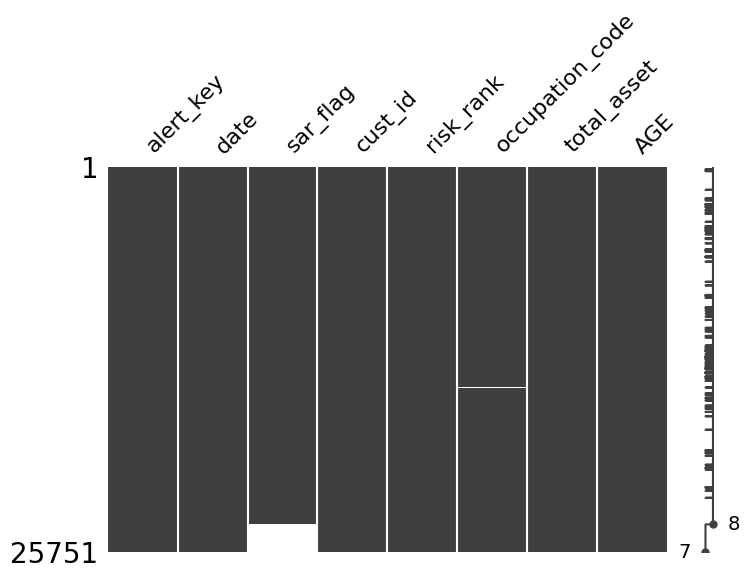

In [3]:
msno.matrix(df, figsize = (8, 5))
# occupation_code有缺失值，sar_flag的缺失值是test資料沒提供預測結果

## Label encoding

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["cust_id"] = le.fit_transform(df["cust_id"])
df.head()

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171142,0,0.0,4962,3,12.0,241719.0,3
1,171152,0,0.0,3772,3,13.0,599497.0,6
2,171177,0,0.0,5052,1,19.0,51160.0,4
3,171178,0,0.0,792,3,9.0,3634343.0,6
4,171180,0,0.0,3080,1,17.0,4076287.0,4


## Feature generation

In [16]:
#cust_id是否曾經洗錢過
df["cust_id_sar"] = 0
sar = df.query("sar_flag == 1")
sar_cust_id = sar["cust_id"].unique()

a = 0
g = df.groupby("cust_id")
for i in sar_cust_id:
    df1 = g.get_group(i)
    sar_idx1 = np.where(df1["sar_flag"])[0][0]
    sar_idx2 = df1.iloc[sar_idx1+1:].index
    df.loc[sar_idx2, "cust_id_sar"] = 1

In [17]:
#total_asset的成長率
df2 = pd.DataFrame()
g = df.groupby("cust_id")
cat = g.size().index
for i in cat:
    df1 = g.get_group(i)
    df1["total_asset"] = df1["total_asset"].pct_change().fillna(0)
    df1["total_asset_change"] =  df1.eval("total_asset != 0").astype(int)
    df1["total_asset"] = df1["total_asset"].replace(np.inf, 0) # total_asset從0增加到某個值的樣本都沒有洗錢，可以0取代inf

    df2 = pd.concat([df1, df2], ignore_index = True)
df2 = df2.sort_values("alert_key").reset_index(drop = True)
df = df2.copy()

des = df.describe().T
des["unique"] = df.nunique()
des

## Split train & test data

In [5]:
train = df.iloc[:-1845]
print(train.shape)
train.head()

(23906, 8)


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171142,0,0.0,4962,3,12.0,241719.0,3
1,171152,0,0.0,3772,3,13.0,599497.0,6
2,171177,0,0.0,5052,1,19.0,51160.0,4
3,171178,0,0.0,792,3,9.0,3634343.0,6
4,171180,0,0.0,3080,1,17.0,4076287.0,4


In [6]:
test = df.iloc[-1845:]
print(test.shape)
test.head()

(1845, 8)


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
23906,352249,365,NaN,3912,1,19.0,1465816.0,7
23907,352253,365,NaN,5393,1,2.0,98177.0,2
23908,352254,365,NaN,6924,1,19.0,2052922.0,7
23909,352280,365,NaN,3431,3,15.0,201906.0,5
23910,352282,365,NaN,84,1,12.0,7450.0,5


## Missing value

In [7]:
null_sar = train[train.isnull().any(axis = 1)]["sar_flag"].sum()
print(f"有缺失值的樣本中sar_flag為1的數量: {round(null_sar)}")

null_feat = train.isnull().sum()
null_feat = pd.DataFrame(null_feat, columns = ["count"])
null_feat["prob"] = null_feat["count"]/len(train)
null_feat = null_feat.query("count != 0")
null_feat

有缺失值的樣本中sar_flag為1的數量: 0


,count,prob
occupation_code,116,0.004852


In [8]:
# occupation_code的缺失值比重不高，刪除
train = train.dropna()

In [9]:
train[train.isnull().any(axis = 1)]

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE


In [10]:
test[test.drop("sar_flag", axis = 1).isnull().any(axis = 1)]

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE


## Correlation

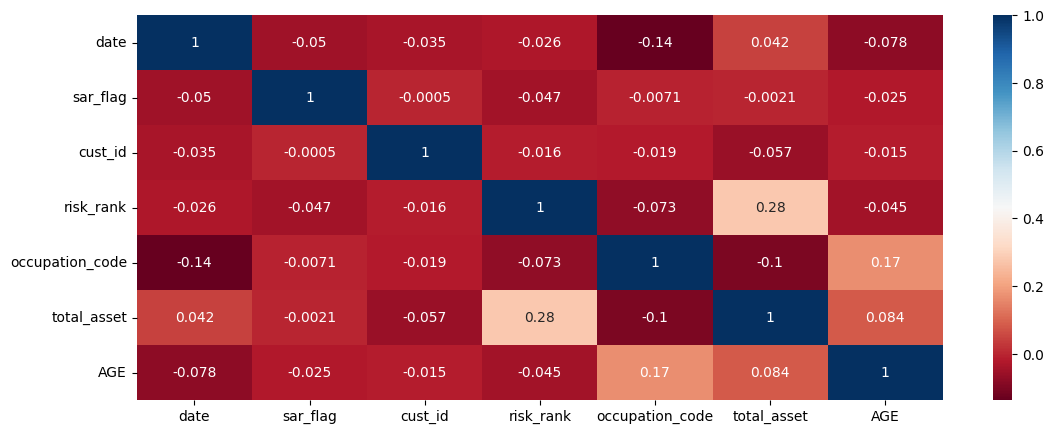

In [11]:
plt.figure(figsize=(13, 5))
corr = train.iloc[:, 1:].corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

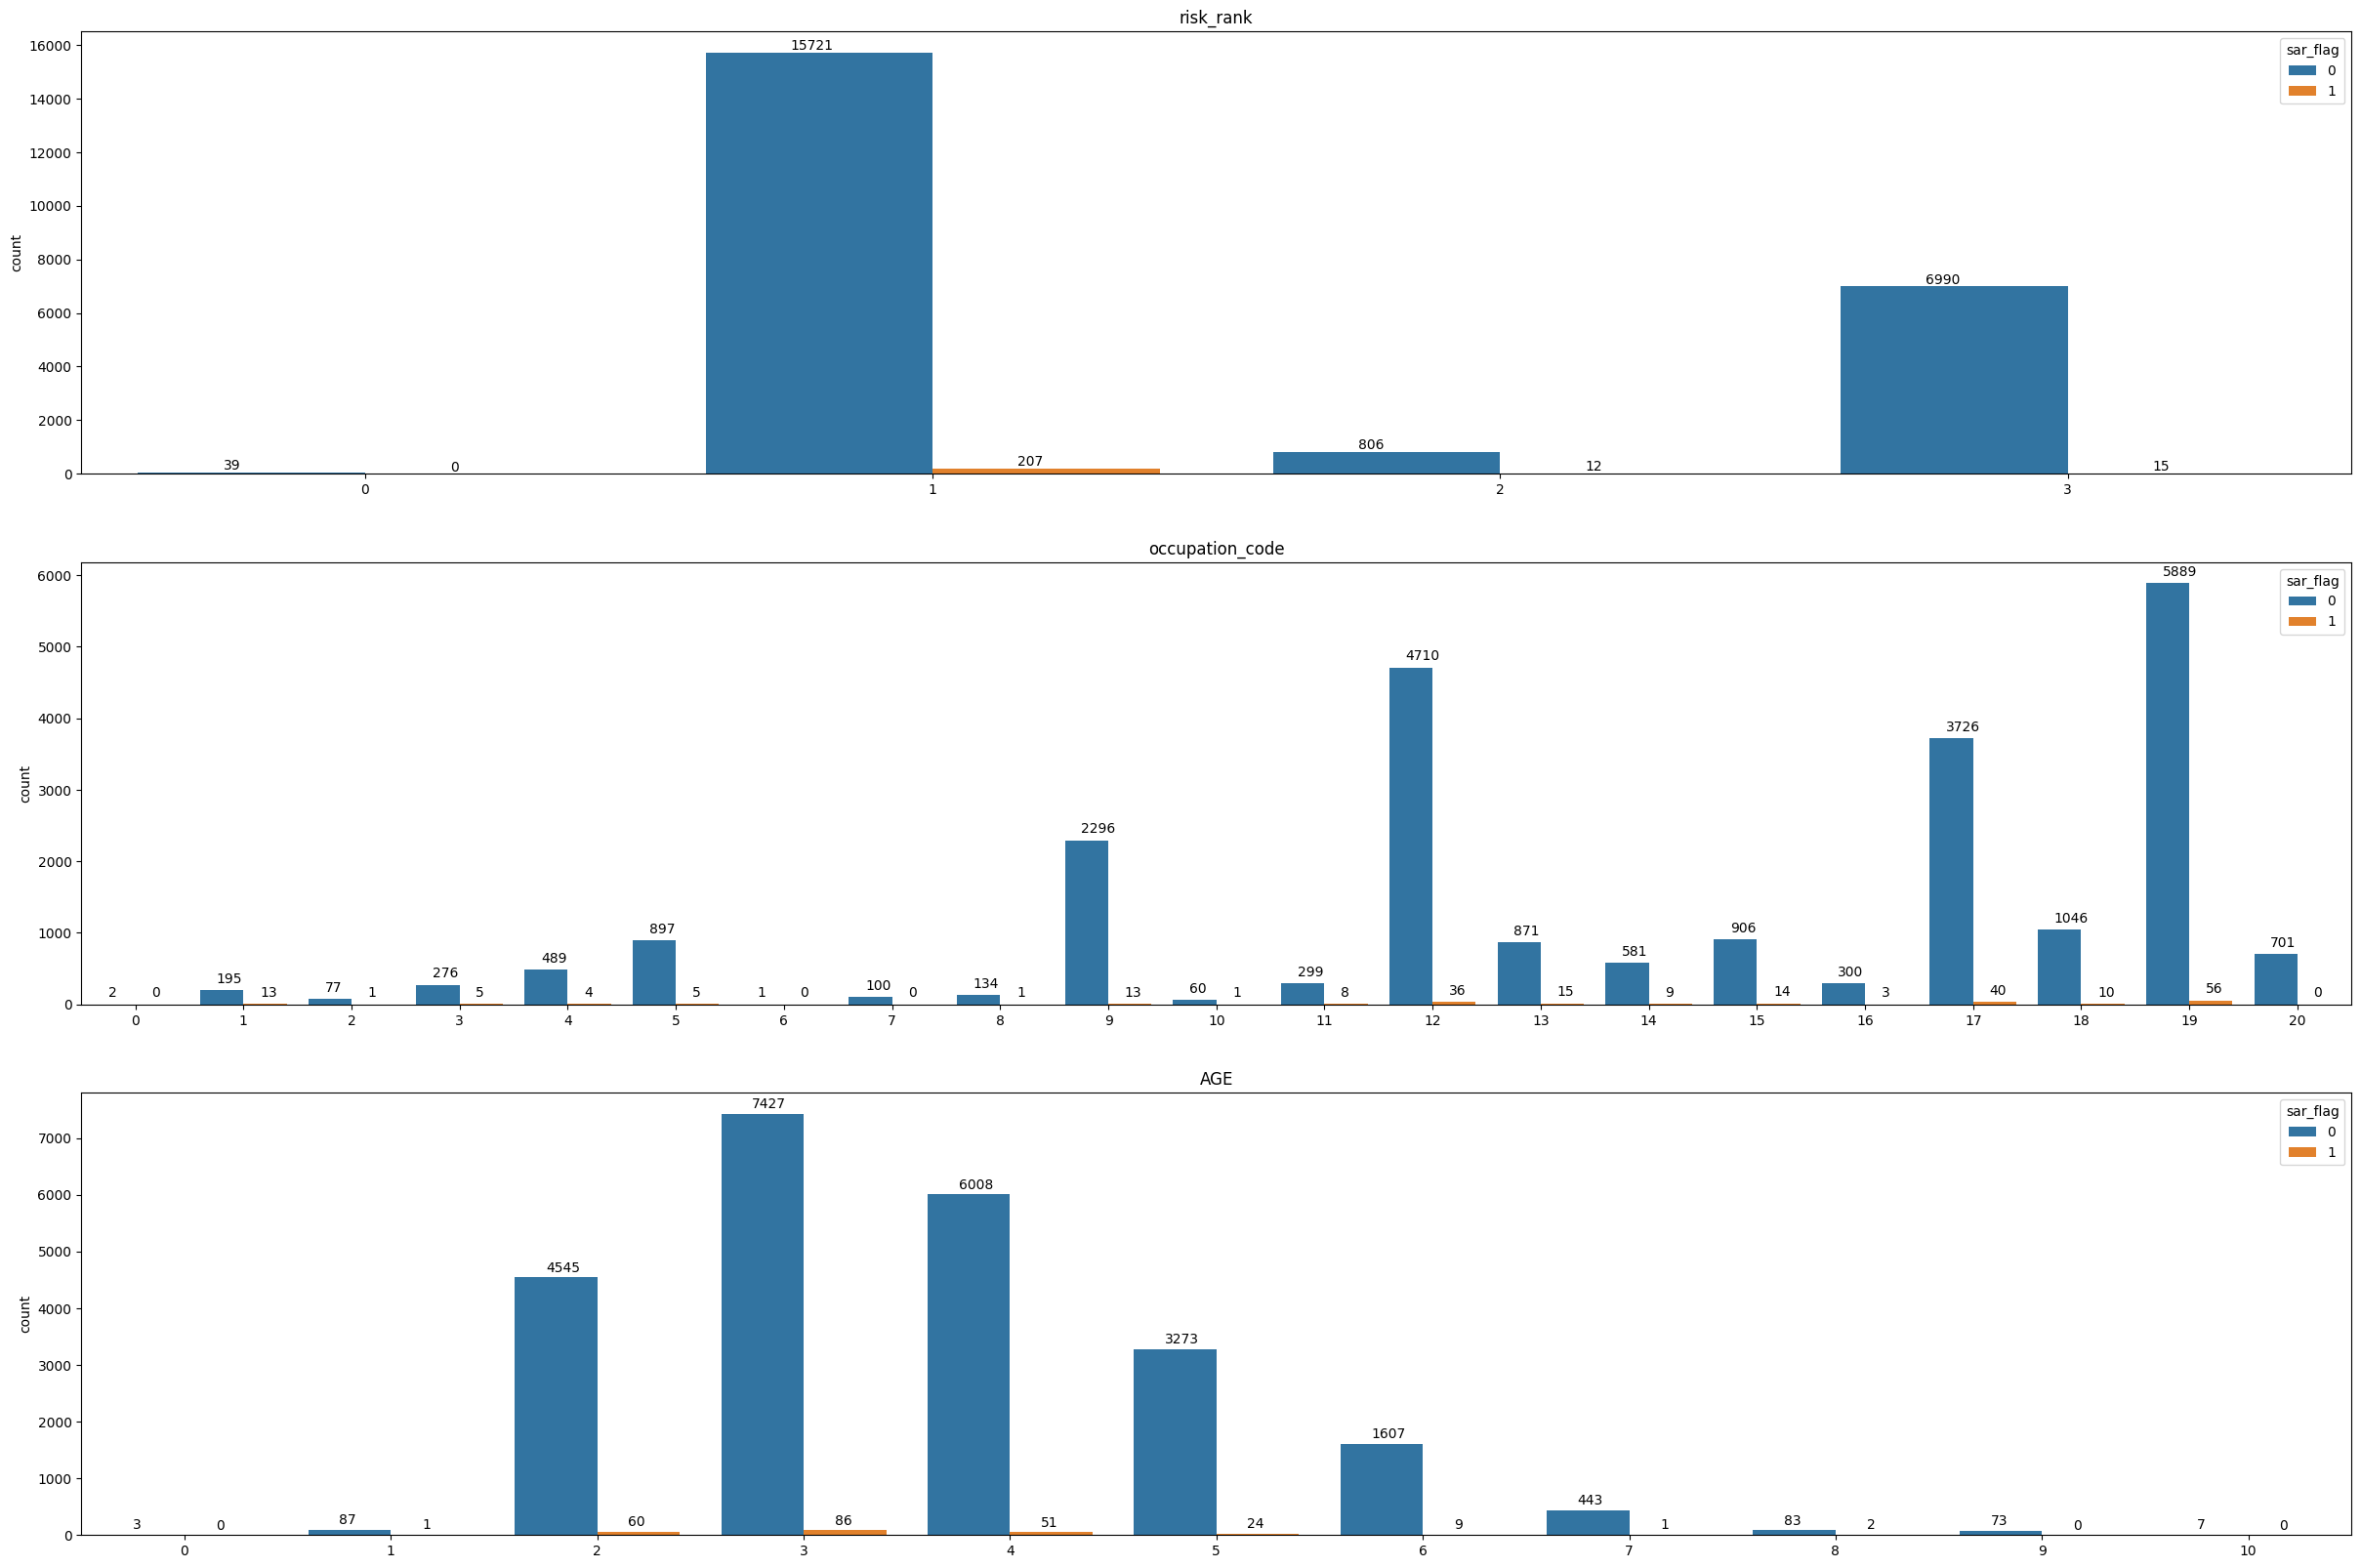

In [12]:
train[["occupation_code", "sar_flag"]] = train[["occupation_code", "sar_flag"]].astype(int)
feat = ["risk_rank", "occupation_code", "AGE"]

a, b = 3, 1
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 20))
for i in range(a):
    for j in range(b):
        sns.countplot(x = feat[k], hue = "sar_flag", data = train, ax = ax[i])
        ax[i].set(xlabel = None, title = feat[k])
        ax[i].legend(title = "sar_flag", loc='upper right')

        for p in ax[i].patches:
            if np.isnan(p.get_height()):
                continue
            ax[i].annotate(f'\n{int(p.get_height())}', (p.get_x()+0.15, p.get_height()+100), size=10)

        k += 1
# plt.suptitle("Category variable", size = 15)
plt.show()

## Adversarial validation

In [15]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, cv


def adversarial(train, test):
    # add train, test label
    train["AV"] = 0
    test["AV"] = 1

    # merge train, test
    df1 = pd.concat([train, test], ignore_index = True)

    # shuffle data
    df1_shuffled = df1.sample(frac=1)

    # create XGBoost data structure
    X = df1_shuffled.drop(['AV'], axis=1)
    y = df1_shuffled['AV']
    XGBdata = xgb.DMatrix(data = X, label = y)

    # XGBoost parameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        'learning_rate': 0.05,
        'max_depth': 5
        }

    # perform cross validation with XGBoost
    cross_val_results = cv(
        dtrain = XGBdata,
        params = params, 
        nfold = 5,
        metrics = "auc", 
        num_boost_round = 200,
        early_stopping_rounds = 20,
        as_pandas = True
        )

    # final result
    print("Accuracy:", cross_val_results["test-auc-mean"].iloc[-1])


    classifier = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)
    classifier.fit(X, y)
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_importance(classifier, ax=ax, max_num_features = 10, height  = 0.5)
    plt.show()

Accuracy: 0.6425591333811396


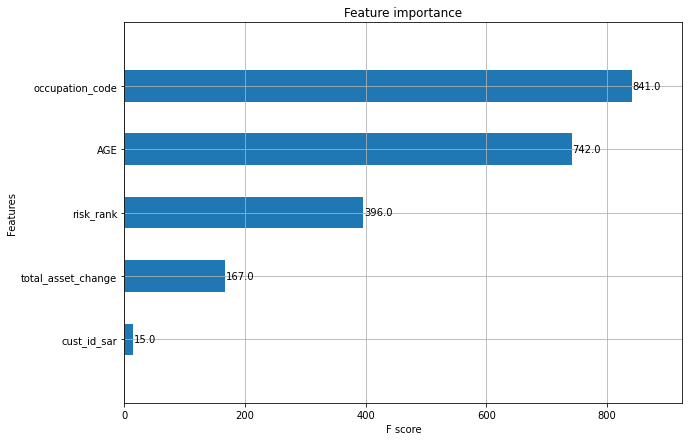

In [16]:
drop_feat = ["alert_key", "date", "sar_flag", "cust_id", "total_asset"]
train1 = train.drop(drop_feat, axis = 1).copy()
test1 = test.drop(drop_feat, axis = 1).copy()

# adversarial validation
adversarial(train1, test1)

In [17]:
des = train.describe().T
des["unique"] = train.nunique()
des

,count,mean,std,min,25%,50%,75%,max,unique
alert_key,23790.0,258564.454098,54631.845904,171142.0,208562.75,259228.0,306026.0,352132.000000,23790
date,23790.0,184.224464,110.977888,0.0,84.00,195.0,280.0,364.000000,243
sar_flag,23790.0,0.009836,0.098690,0.0,0.00,0.0,0.0,1.000000,2
cust_id,23790.0,3688.322783,2232.271386,0.0,1747.00,3682.0,5489.0,7707.000000,7214
risk_rank,23790.0,1.621648,0.909625,0.0,1.00,1.0,3.0,3.000000,4
occupation_code,23790.0,14.275998,4.672051,0.0,12.00,15.0,19.0,20.000000,21
total_asset,23790.0,1.817505,97.271860,-1.0,0.00,0.0,0.0,10321.677215,2466
AGE,23790.0,3.647289,1.312934,0.0,3.00,3.0,4.0,10.000000,11
cust_id_sar,23790.0,0.000168,0.012966,0.0,0.00,0.0,0.0,1.000000,2
total_asset_change,23790.0,0.107524,0.309785,0.0,0.00,0.0,0.0,1.000000,2


In [18]:
des = test.describe().T
des["unique"] = test.nunique()
des

,count,mean,std,min,25%,50%,75%,max,unique
alert_key,1845.0,358724.454743,3561.987663,352249.0,355759.0,358472.0,361594.0,365073.000000,1845
date,1845.0,380.241192,7.769164,365.0,375.0,378.0,386.0,393.000000,19
sar_flag,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
cust_id,1845.0,3782.423306,2142.621504,25.0,2069.0,3782.0,5559.0,7706.000000,735
risk_rank,1845.0,1.511111,0.855955,0.0,1.0,1.0,2.0,3.000000,4
occupation_code,1845.0,13.929539,4.905884,1.0,12.0,15.0,18.0,20.000000,18
total_asset,1845.0,1.393245,40.490762,-1.0,0.0,0.0,0.0,1714.428571,199
AGE,1845.0,3.485095,1.273976,1.0,3.0,3.0,4.0,9.000000,9
cust_id_sar,1845.0,0.001626,0.040302,0.0,0.0,0.0,0.0,1.000000,2
total_asset_change,1845.0,0.114363,0.318338,0.0,0.0,0.0,0.0,1.000000,2


## Split train & valid data

In [29]:
drop_feat = ["alert_key", "sar_flag", "date"]
X_train = train.drop(drop_feat, axis = 1)
y_train = train["sar_flag"]

X_test = test.drop(drop_feat, axis = 1)

In [30]:
print(f"raw 1/0: {(y_train.value_counts()[1] / y_train.value_counts()[0]):.4}")
y_train.value_counts()

raw 1/0: 0.009934


0    23556
1      234
Name: sar_flag, dtype: int64

In [31]:
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = train.iloc[:, 2], random_state = 99)
# X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.3, shuffle = False)
# print(X_train1.shape, X_valid.shape, y_train1.shape, y_valid.shape)
print(f"X_train: {X_train1.shape}, X_valid: {X_valid.shape}, X_test: {X_test.shape}\ny_train: {y_train1.shape}, y_valid: {y_valid.shape}")

X_train: (19032, 5), X_valid: (4758, 5), X_test: (1845, 5)
y_train: (19032,), y_valid: (4758,)


In [32]:
print(f"train 1/0: {(y_train1.value_counts()[1] / y_train1.value_counts()[0]):.4}")
y_train1.value_counts()

train 1/0: 0.009923


0    18845
1      187
Name: sar_flag, dtype: int64

In [33]:
print(f"valid 1/0: {(y_valid.value_counts()[1] / y_valid.value_counts()[0]):.4}")
y_valid.value_counts()

valid 1/0: 0.009977


0    4711
1      47
Name: sar_flag, dtype: int64

## Frequency encoding

cat_feat = ["occupation_code", "AGE"] #"risk_rank"
col = cat_feat[0]
for i in col:
    freq_map = X_train1[col].value_counts().to_dict()
    X_train1[col] = X_train1[col].map(freq_map)
    X_valid[col] = X_valid[col].map(freq_map)

cat_feat = ["occupation_code", "AGE"] #"risk_rank"
col = cat_feat[0]
for i in col:
    freq_map = X_train[col].value_counts().to_dict()
    X_train[col] = X_train[col].map(freq_map)
    X_test[col] = X_test[col].map(freq_map)

## Resample

In [34]:
from imblearn.over_sampling import SMOTE, ADASYN
oversample = SMOTE(random_state=99)
X_train1, y_train1 = oversample.fit_resample(X_train1, y_train1)
y_train1.value_counts()

0    18845
1    18845
Name: sar_flag, dtype: int64

In [35]:
oversample = SMOTE(random_state=99)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

0    23556
1    23556
Name: sar_flag, dtype: int64

## Target encoding

In [36]:
import category_encoders as ce

cat_feat = ["occupation_code", "AGE"]
ce_target = ce.TargetEncoder(cols = cat_feat)
X_train1 = ce_target.fit_transform(X_train1, y_train1)
X_valid = ce_target.transform(X_valid)

In [37]:
ce_target = ce.TargetEncoder(cols = ["occupation_code", "AGE"])
X_train = ce_target.fit_transform(X_train, y_train)
X_test = ce_target.transform(X_test)

## Modeling

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state),#, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train1, y_train1)
    print(name + " trained.")

Logistic trained.
Bayes (Gaussian) trained.
KNN trained.
Neural Network trained.
Decision Tree trained.
Random Forest trained.
Gradient Boost trained.
XGBoost trained.
LightGBM trained.
Easy Ensemble (AdaBoost) trained.
Easy Ensemble (Logistic) trained.


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

# acc_bound = 0.7
# f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_valid)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_valid, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_valid, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_valid, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_valid, pred_test).round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    # if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
    col3 = sorted(list(set(y_valid) | set(pred_test)))
    confusion = pd.DataFrame(confusion_matrix(y_valid, pred_test), index = col3, columns = col3)
    confusion["Total"] = confusion.sum(axis = 1)
    confusion.loc["Total"] = confusion.sum(axis = 0)

    
    confusion = confusion.astype(int)
    
    print(f"<< {key.lstrip()} >>")
    print(f"\nConfusion Matrix:\n {confusion}")
    print(f"\nClassification Report:\n{classification_report(y_valid, pred_test)}")
    print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score = score.sort_values(["Recall_test", "Precision_test", "f1_test", "Accuracy_test"], ascending = False)
score

<< Logistic >>

Confusion Matrix:
           0     1  Total
0      1148  3563   4711
1        11    36     47
Total  1159  3599   4758

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.24      0.39      4711
           1       0.01      0.77      0.02        47

    accuracy                           0.25      4758
   macro avg       0.50      0.50      0.21      4758
weighted avg       0.98      0.25      0.39      4758

------------------------------------------------------------
<< Bayes (Gaussian) >>

Confusion Matrix:
          0     1  Total
0      578  4133   4711
1        7    40     47
Total  585  4173   4758

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.12      0.22      4711
           1       0.01      0.85      0.02        47

    accuracy                           0.13      4758
   macro avg       0.50      0.49      0.12      4758
weighted avg      

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,f1_train,f1_test
Bayes (Gaussian),0.53,0.13,0.93,0.85,0.51,0.01,0.66,0.02
Logistic,0.54,0.25,0.84,0.77,0.52,0.01,0.64,0.02
Easy Ensemble (Logistic),0.54,0.25,0.84,0.77,0.52,0.01,0.64,0.02
Easy Ensemble (AdaBoost),0.80,0.76,0.84,0.45,0.78,0.02,0.81,0.04
Gradient Boost,0.84,0.80,0.88,0.43,0.81,0.02,0.84,0.04
LightGBM,0.90,0.88,0.91,0.38,0.90,0.03,0.90,0.06
XGBoost,0.91,0.92,0.87,0.28,0.94,0.04,0.91,0.07
KNN,0.83,0.85,0.77,0.28,0.88,0.02,0.82,0.03
Random Forest,0.93,0.96,0.89,0.26,0.97,0.07,0.93,0.11
Decision Tree,0.91,0.96,0.84,0.26,0.98,0.06,0.91,0.10


In [40]:
best_model = score.index[0]
best_model

'Bayes (Gaussian)'

## Recall@N - 1 的 Precision

In [29]:
pred_valid  = models[best_model].predict_proba(X_valid)
pred_valid = pred_valid[:, 1]

valid = train.loc[y_valid.index]
valid = valid[["alert_key", "sar_flag"]]
valid["probability"] = pred_valid
valid = valid.sort_values("probability", ascending = False)
sar = np.where(valid["sar_flag"])[0]
recall = len(sar)/sar[-2]
print(f"total: {len(valid)},  SAR: {len(sar)}\n{len(sar)} / {sar[-1]} = {recall:.6}")

total: 7137,  SAR: 22
22 / 5816 = 0.00417141


## Submit

In [30]:
X_train = train.drop(drop_feat, axis = 1)
y_train = train[["sar_flag"]]

#### No valid: only use X_train to train

In [31]:
test_model = models[best_model]

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 1034


array([0.04201874, 0.4656892 , 0.38478881, ..., 0.03850842, 0.76669712,
       0.07775756])

#### Total train: use X_train and X_valid to train

In [32]:
test_model = models[best_model]
test_model.fit(X_train, y_train)

pred_prob = test_model.predict_proba(X_test)
pred_prob = pred_prob[:, 1]
print("1:",  (pred_prob > 0.5).sum())
pred_prob

1: 2


array([0.00302438, 0.00759287, 0.00464322, ..., 0.00122489, 0.02315046,
       0.00216927])

In [33]:
result = test[["alert_key"]]
result["probability"] = pred_prob
# result["probability"] = result["probability"].replace(0, 1e-4).replace(1, 1-1e-4)
result

,alert_key,probability
23906,352249,0.003024
23907,352253,0.007593
23908,352254,0.004643
23909,352280,0.000767
23910,352282,0.008126
...,...,...
25746,365001,0.015421
25747,365004,0.003291
25748,365008,0.001225
25749,365009,0.023150


In [34]:
X_train.columns

Index(['risk_rank', 'occupation_code', 'AGE', 'cust_id_sar',
       'total_asset_change'],
      dtype='object')

In [35]:
submit = pd.read_csv("D:\\Julie\\develop\\money_laundry\\data\\預測的案件名單及提交檔案範例.csv")
submit = submit[["alert_key"]]
submit = pd.merge(submit, result, on = "alert_key", how = "left")
submit["probability"] = submit["probability"].astype(float)
submit = submit.fillna(1e-5)
submit = submit.sort_values("probability", ascending = False)
submit

,alert_key,probability
3723,354939,0.979933
1173,362733,0.957445
432,358464,0.208714
57,354047,0.208714
3432,357883,0.208714
...,...,...
1648,371071,0.000010
1650,369630,0.000010
1651,373443,0.000010
1652,374325,0.000010


In [36]:
submit.to_csv("data/submit/origin.csv", index = False)